In [2]:
from db import db, query, query_list
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
import scipy.stats as st

In [4]:
sns.set_style('darkgrid')

In [5]:
df = query('SELECT * FROM beers_clean')

### Initial EDA

In [53]:
# Missing Values
df.isna().sum()

name                    0
beer_url                0
abv                    74
price                 263
bar_url                 0
size                  307
kind                   17
establishment_type    419
bar_name                0
county_name             0
beer_category          95
origin_zone           318
dtype: int64

In [59]:
df.describe()

,abv,price,size
count,7763.000000,7574.000000,7530.000000
mean,6.316263,9.554831,13.823592
std,2.046017,7.429275,3.563597
min,0.000000,0.550000,1.000000
25%,5.000000,7.000000,12.000000
50%,5.750000,8.000000,12.000000
75%,7.000000,10.000000,16.000000
max,29.000000,350.000000,25.400000


## Quantitative Variables

/Users/rcharan/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/rcharan/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


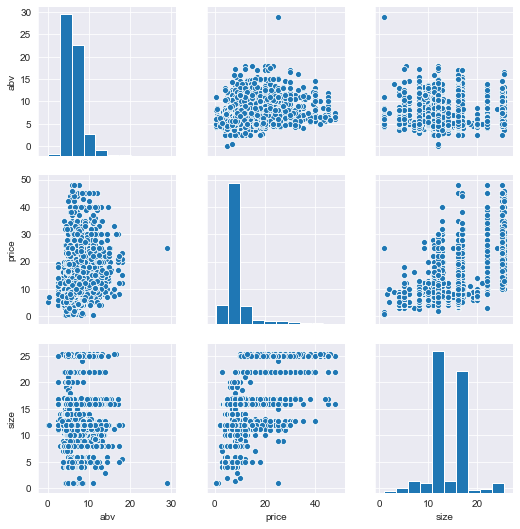

In [67]:
sns.pairplot(df[df.price < 50])

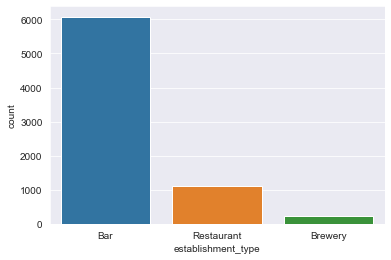

In [72]:
sns.countplot(x = 'establishment_type', data = df)

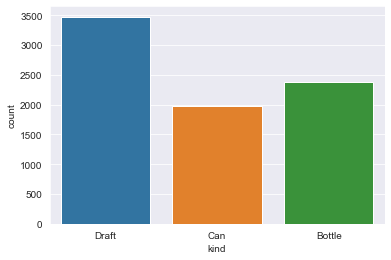

In [73]:
sns.countplot(x = 'kind', data = df)

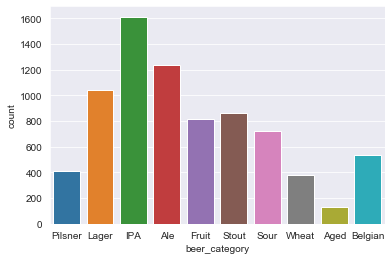

In [74]:
sns.countplot(x = 'beer_category', data = df)

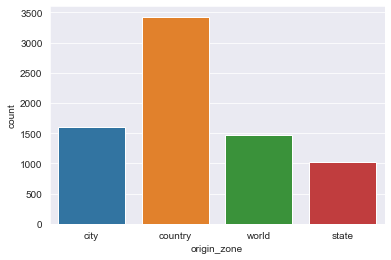

In [75]:
sns.countplot(x = 'origin_zone', data = df)

## Are certain beer styles more popular in each borough?

### Chi-square test for independence

##### H0: Borough has no effect on the popularity of a beer style.

##### Ha: (Style) IPAs are more popular in (borough) Brooklyn.

In [77]:
# Exclude the bronx because it has not enough data
test1_data = df.loc[df.county_name != 'Bronx',['county_name', 'beer_category']].dropna()
test1_table = test1_data.pivot_table(index = 'county_name', columns = 'beer_category', aggfunc = len)
test1_table

beer_category,Aged,Ale,Belgian,Fruit,IPA,Lager,Pilsner,Sour,Stout,Wheat
county_name,,,,,,,,,,
Kings,37,433,134,254,476,306,129,273,280,101
New York,68,589,324,394,870,435,202,362,417,209
Queens,12,130,47,95,186,180,54,56,112,47
Richmond,11,79,33,67,76,124,23,30,48,22


In [76]:
chi2, p, dof, ex = st.chi2_contingency(test1_table)
print(f'chi2 : {chi2}\np    : {p}\ndof  : {dof}')

chi2 : 173.65398219919535
p    : 2.2809906367857478e-23
dof  : 27


In [80]:
# Look at the frequency table
row_freq = test1_table.apply(lambda s : s/s.sum(), axis = 'columns')
round(row_freq*100,1)

beer_category,Aged,Ale,Belgian,Fruit,IPA,Lager,Pilsner,Sour,Stout,Wheat
county_name,,,,,,,,,,
Kings,1.5,17.9,5.5,10.5,19.6,12.6,5.3,11.3,11.6,4.2
New York,1.8,15.2,8.4,10.2,22.5,11.2,5.2,9.4,10.8,5.4
Queens,1.3,14.1,5.1,10.3,20.2,19.6,5.9,6.1,12.2,5.1
Richmond,2.1,15.4,6.4,13.1,14.8,24.2,4.5,5.8,9.4,4.3


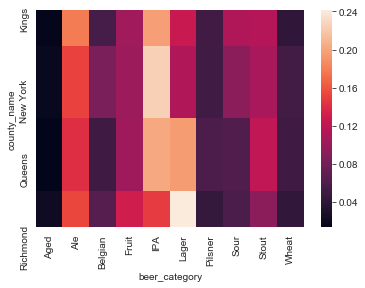

In [81]:
sns.heatmap(row_freq)

#### Does price (per oz) increase as ABV increases?

In [6]:
df['price_per_oz'] = df['size']/df['price']

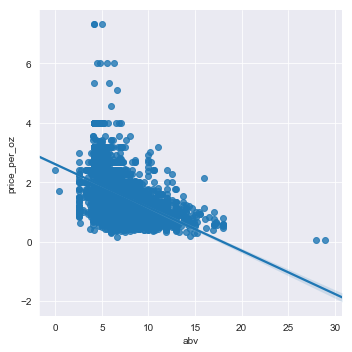

In [9]:
sns.lmplot('abv', 'price_per_oz', data=df)

In [10]:
temp_df = df[df.abv < 20]

In [11]:
df.describe()

,abv,price,size,price_per_oz
count,7763.000000,7574.000000,7530.000000,7450.000000
mean,6.316263,9.554831,13.823592,1.686507
std,2.046017,7.429275,3.563597,0.619130
min,0.000000,0.550000,1.000000,0.040000
25%,5.000000,7.000000,12.000000,1.333333
50%,5.750000,8.000000,12.000000,1.714286
75%,7.000000,10.000000,16.000000,2.000000
max,29.000000,350.000000,25.400000,7.333333


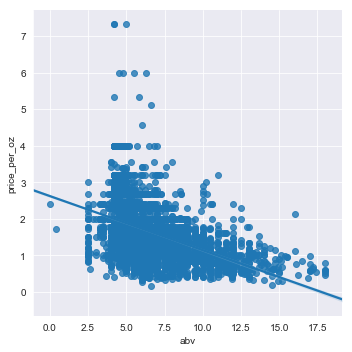

In [12]:
sns.lmplot('abv', 'price_per_oz', data=temp_df)

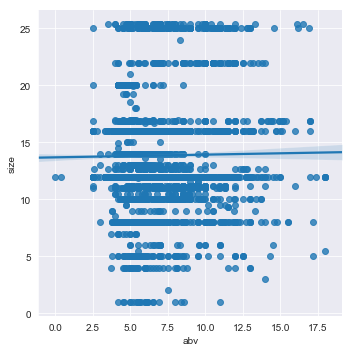

In [13]:
sns.lmplot('abv', 'size', data=temp_df)

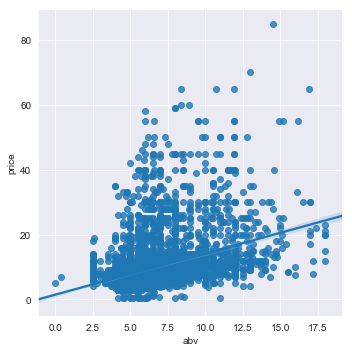

In [14]:
sns.lmplot('abv', 'price', data=temp_df)

In [23]:
temp_df['alcohol_content'] = temp_df['abv']*temp_df['size']/100

/Users/davebletsch/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


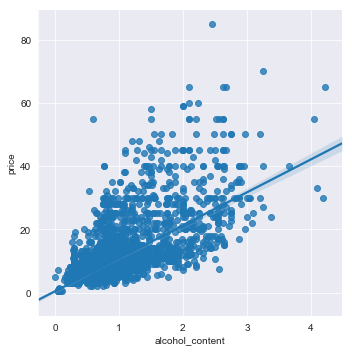

In [24]:
sns.lmplot('alcohol_content', 'price', data=temp_df)

In [25]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

results = smf.ols('price ~ alcohol_content', data=temp_df, ).fit()

In [27]:
sm.stats.anova_lm(results, typ = 2)

,sum_sq,df,F,PR(>F)
alcohol_content,125912.621957,1.0,5541.006519,0.0
Residual,167656.060611,7378.0,NaN,NaN


In [26]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     5541.
Date:                Thu, 14 Nov 2019   Prob (F-statistic):               0.00
Time:                        17:47:08   Log-Likelihood:                -21996.
No. Observations:                7380   AIC:                         4.400e+04
Df Residuals:                    7378   BIC:                         4.401e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4122      0.135      3.064      0.002       0.149       0.676
alcohol_content    10.4288      0.140     74.438      0.000      10.154      10.703
==============================================================================
Omnibus:                     5561.329   Durbin-Watson:                   1.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           140532.689
Skew:                           3.396   Prob(JB):                         0.00
Kurtosis:                      23.270   Cond. No.                         4.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Locality of brewer
